<a href="https://colab.research.google.com/github/Bosy-Ayman/DSAI-402-RL/blob/main/assignments-solution/Assignment5_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from collections import defaultdict
import random

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:

class GridWorld:
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.start = (0, 0)
        self.goal = (4, 4)
        self.obstacles = [(1, 1), (2, 2), (3, 1)]
        self.actions = ['up', 'down', 'left', 'right']
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x, y = self.state

        if action == 'up' and x > 0:
            x -= 1
        elif action == 'down' and x < self.height - 1:
            x += 1
        elif action == 'left' and y > 0:
            y -= 1
        elif action == 'right' and y < self.width - 1:
            y += 1

        next_state = (x, y)

        if next_state in self.obstacles:
            reward = -2
            done = False
        elif next_state == self.goal:
            reward = 10
            done = True
        else:
            reward = -0.1
            done = False

        self.state = next_state
        return next_state, reward, done

    def get_random_action(self):
        return random.choice(self.actions)

In [ ]:

class MonteCarlo:
    def __init__(self, env, gamma=0.9, alpha=0.1):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))
        self.returns = defaultdict(list)
        self.episode_history = []

    def generate_episode(self, epsilon=0.1):
        state = self.env.reset()
        episode = []
        done = False

        while not done:
            # Epsilon-greedy policy
            if random.random() < epsilon:
                action_idx = random.randint(0, len(self.env.actions) - 1)
            else:
                action_idx = np.argmax(self.Q[state])

            action = self.env.actions[action_idx]
            next_state, reward, done = self.env.step(action)

            episode.append((state, action_idx, reward))
            state = next_state

        self.episode_history.append(episode)
        return episode

    def update_value_function(self, episode):
        G = 0
        states_visited = set()

        # Process episode backwards
        for t in range(len(episode) - 1, -1, -1):
            state, action_idx, reward = episode[t]
            G = self.gamma * G + reward

            # First visit MC
            if state not in states_visited:
                states_visited.add(state)
                self.returns[(state, action_idx)].append(G)
                self.Q[state][action_idx] = np.mean(self.returns[(state, action_idx)])

In [ ]:
class TemporalDifference:
    def __init__(self, env, gamma=0.9, alpha=0.1):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))
        self.episode_history = []

    def generate_episode(self, epsilon=0.1):
        state = self.env.reset()
        episode = []
        done = False

        while not done:

            if random.random() < epsilon:
                action_idx = random.randint(0, len(self.env.actions) - 1)
            else:
                action_idx = np.argmax(self.Q[state])

            action = self.env.actions[action_idx]
            next_state, reward, done = self.env.step(action)

            episode.append((state, action_idx, reward, next_state))

            # TD update
            if next_state is not None:
                td_target = reward + self.gamma * np.max(self.Q[next_state])
                td_error = td_target - self.Q[state][action_idx]
                self.Q[state][action_idx] += self.alpha * td_error

            state = next_state

        self.episode_history.append(episode)
        return episode


In [21]:
def create_visualization(env, mc_agent, td_agent, episode_num):
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig)

    # --- Monte Carlo Episode Path ---
    ax_mc_ep = fig.add_subplot(gs[1, 0:3])
    if mc_agent.episode_history:
        current_episode = mc_agent.episode_history[-1]
        plot_episode_path(ax_mc_ep, env, current_episode, f"Monte Carlo - Episode {episode_num}")

    # --- Monte Carlo Value Function ---
    ax_mc_v = fig.add_subplot(gs[0, 0:2])
    plot_value_function(ax_mc_v, mc_agent.Q, env, "MC Value Function")

    # --- TD Episode Path ---
    ax_td_ep = fig.add_subplot(gs[2, 0:3])
    if td_agent.episode_history:
        current_episode = td_agent.episode_history[-1]
        plot_episode_path(ax_td_ep, env, current_episode, f"TD - Episode {episode_num}")

    # --- TD Value Function ---
    ax_td_v = fig.add_subplot(gs[0, 2])
    plot_value_function(ax_td_v, td_agent.Q, env, "TD Value Function")

    plt.tight_layout()
    plt.show()
    return fig


In [ ]:
def plot_episode_path(ax, env, episode, title):
    ax.clear()
    ax.set_xlim(-0.5, env.width - 0.5)
    ax.set_ylim(-0.5, env.height - 0.5)
    ax.set_xticks(np.arange(env.width))
    ax.set_yticks(np.arange(env.height))
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()

    # Obstacles
    for obs in env.obstacles:
        ax.add_patch(patches.Rectangle((obs[1]-0.5, obs[0]-0.5), 1, 1,
                                       facecolor='red', alpha=0.5))

    # Start and goal
    ax.plot(env.start[1], env.start[0], 'go', markersize=15, label='Start')
    ax.plot(env.goal[1], env.goal[0], 'bo', markersize=15, label='Goal')

    # Episode path
    if episode:
        states = [step[0] for step in episode]
        y_coords = [s[0] for s in states]
        x_coords = [s[1] for s in states]
        ax.plot(x_coords, y_coords, 'o-', color='purple', alpha=0.8, linewidth=2, label='Path')

    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=10)

In [ ]:
def plot_value_function(ax, Q, env, title):
    ax.clear()
    value_grid = np.zeros((env.height, env.width))

    for i in range(env.height):
        for j in range(env.width):
            state = (i, j)
            if state in Q:
                value_grid[i, j] = np.max(Q[state])

    # Heatmap
    im = ax.imshow(value_grid, cmap='viridis', origin='upper', interpolation='nearest')

    # Text annotations
    for i in range(env.height):
        for j in range(env.width):
            color = "white" if value_grid[i, j] < np.max(value_grid)/2 else "black"
            ax.text(j, i, f'{value_grid[i, j]:.1f}', ha='center', va='center', color=color)

    ax.set_title(title)
    ax.set_xticks(np.arange(env.width))
    ax.set_yticks(np.arange(env.height))
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

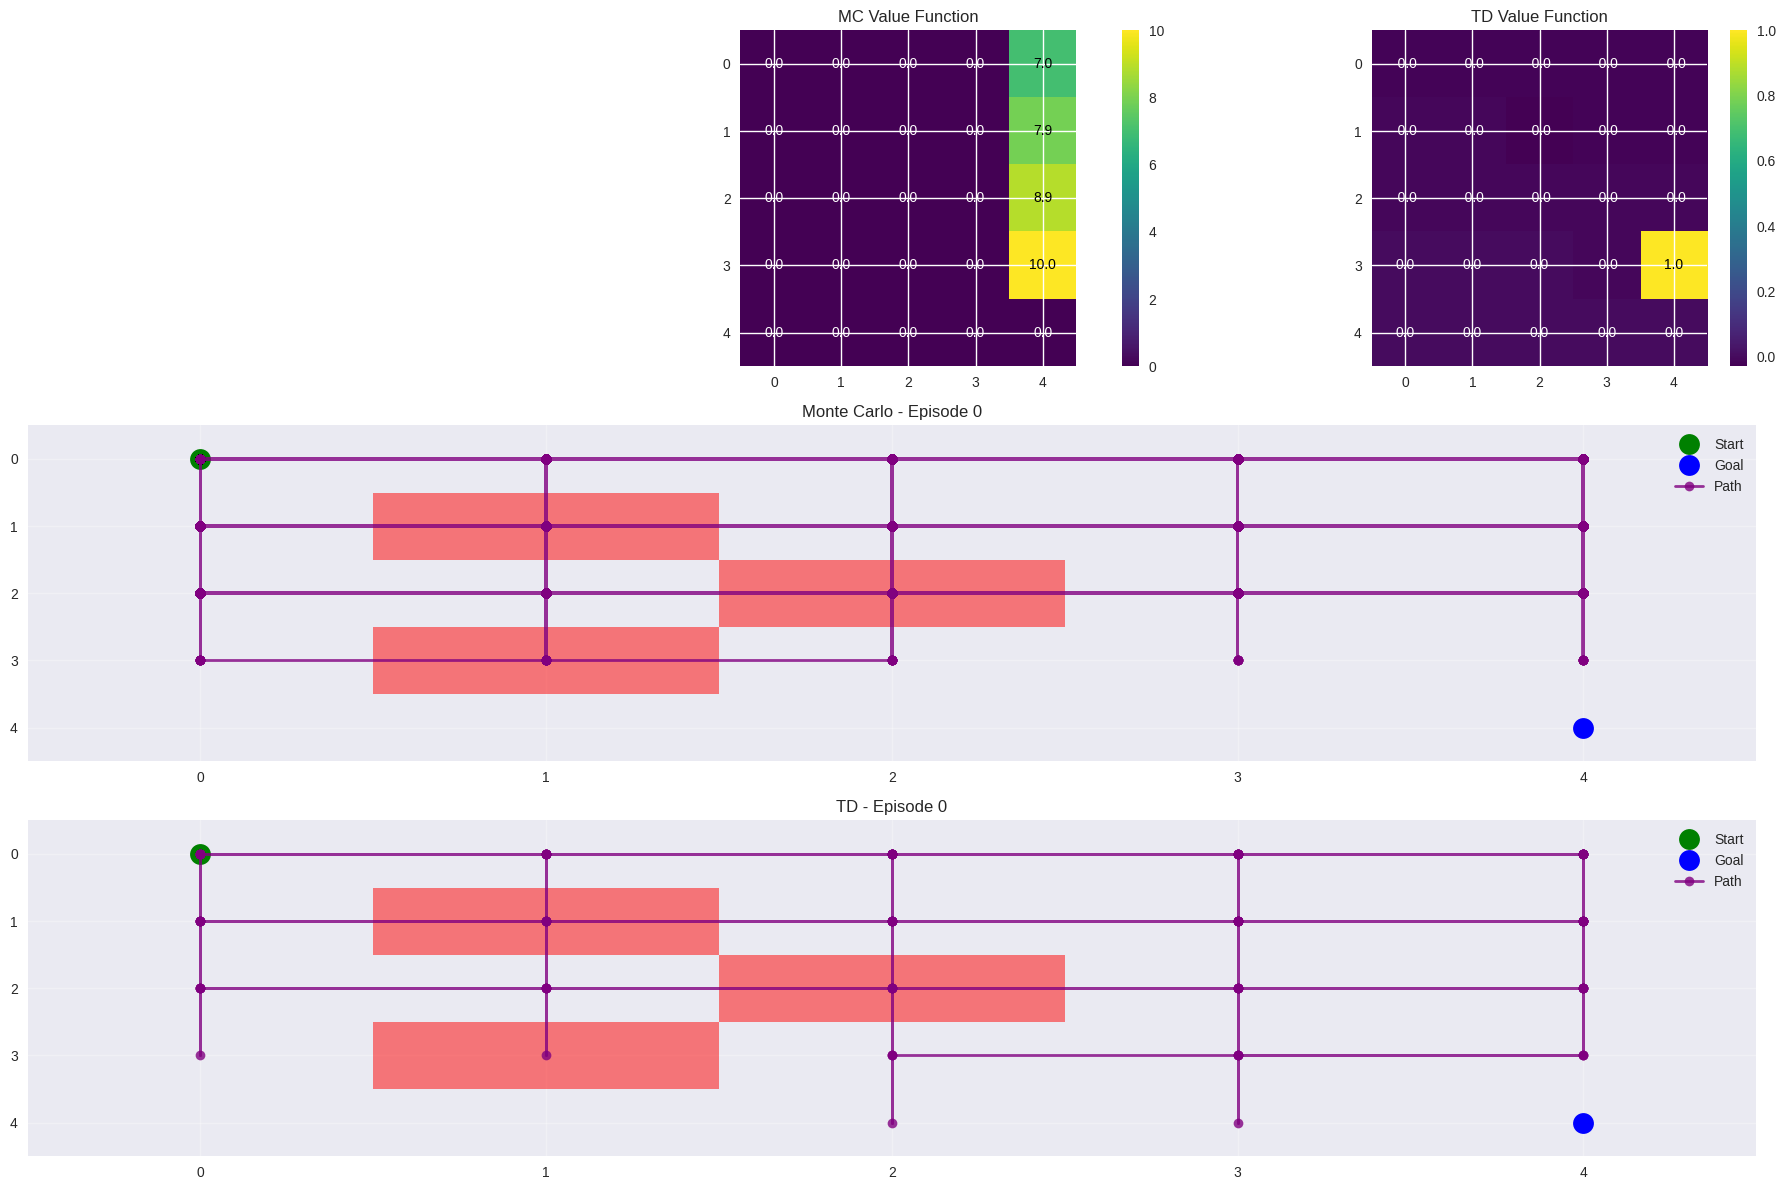

<Figure size 800x550 with 0 Axes>

Episode 0: MC Return = -268561.2, TD Return = -25.5


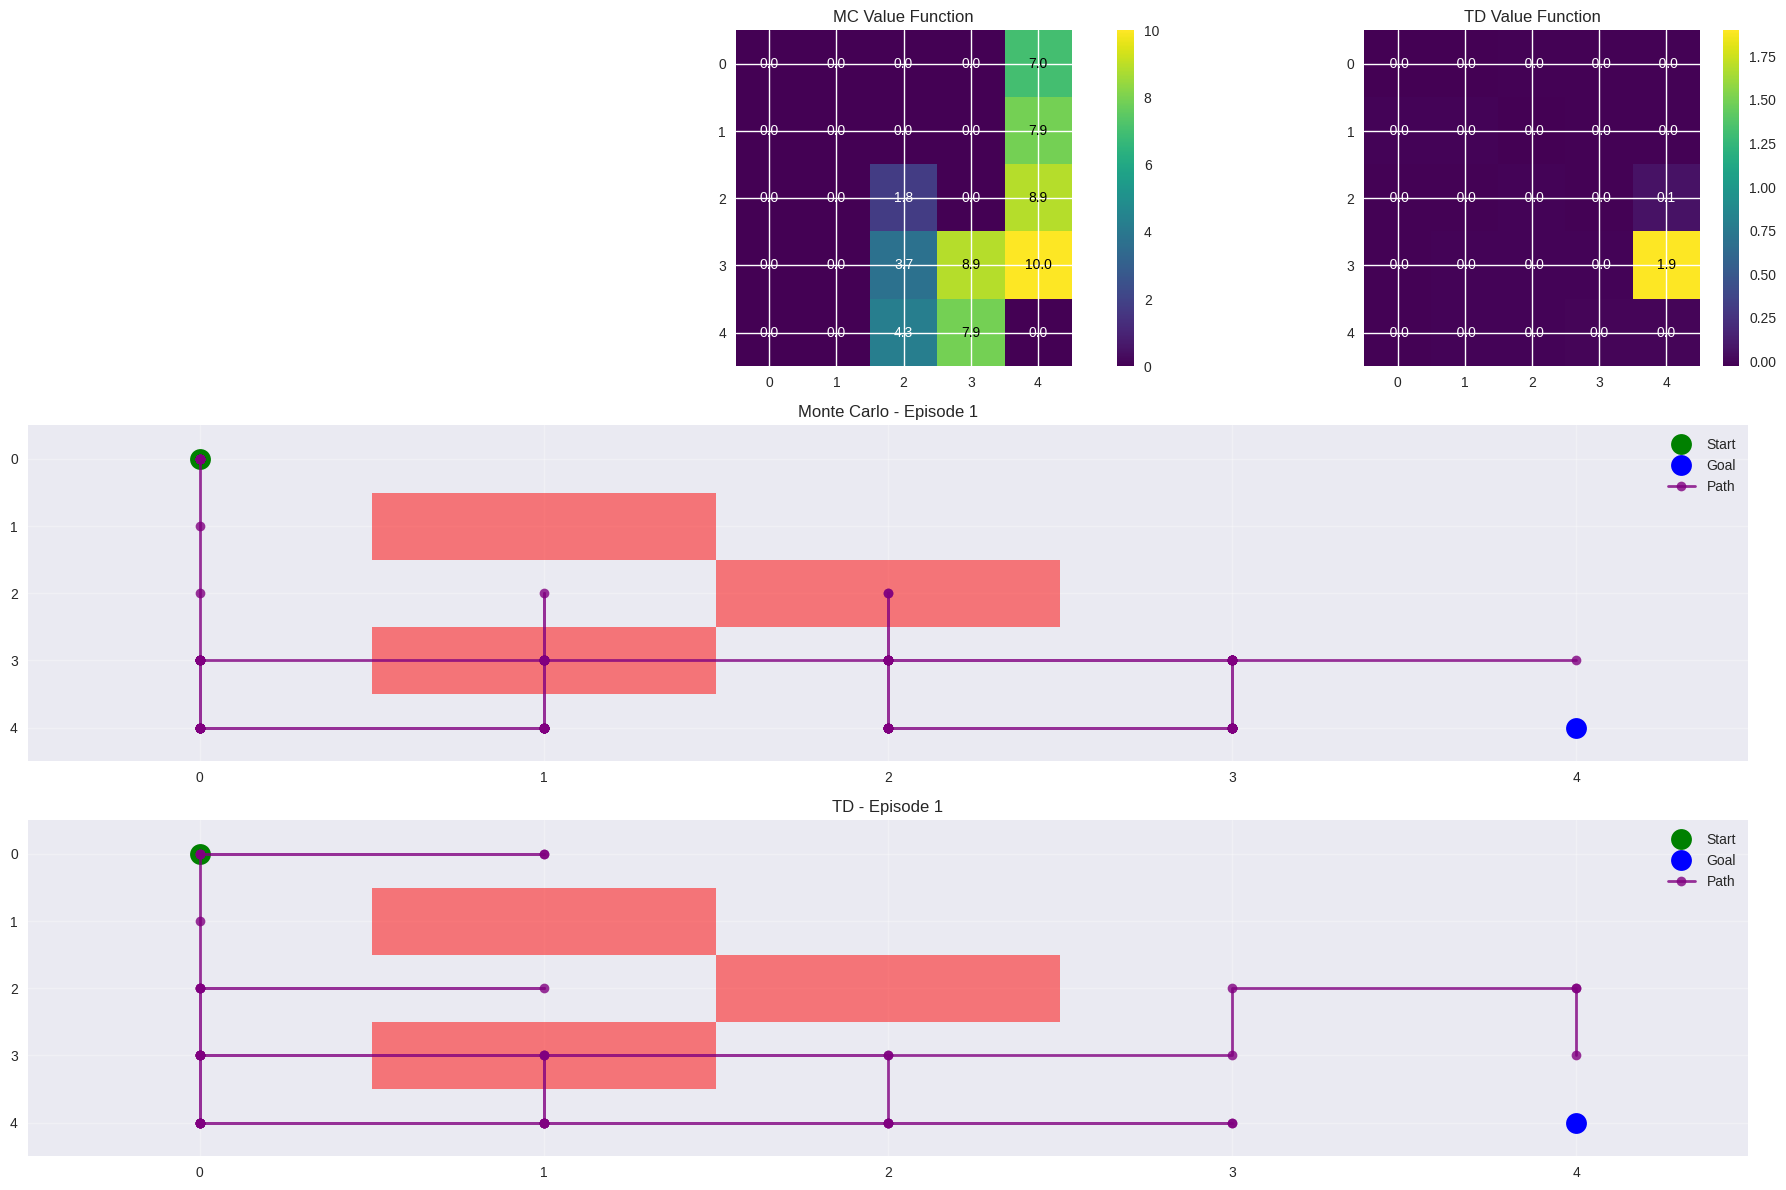

<Figure size 800x550 with 0 Axes>

Episode 1: MC Return = -70.8, TD Return = -0.5


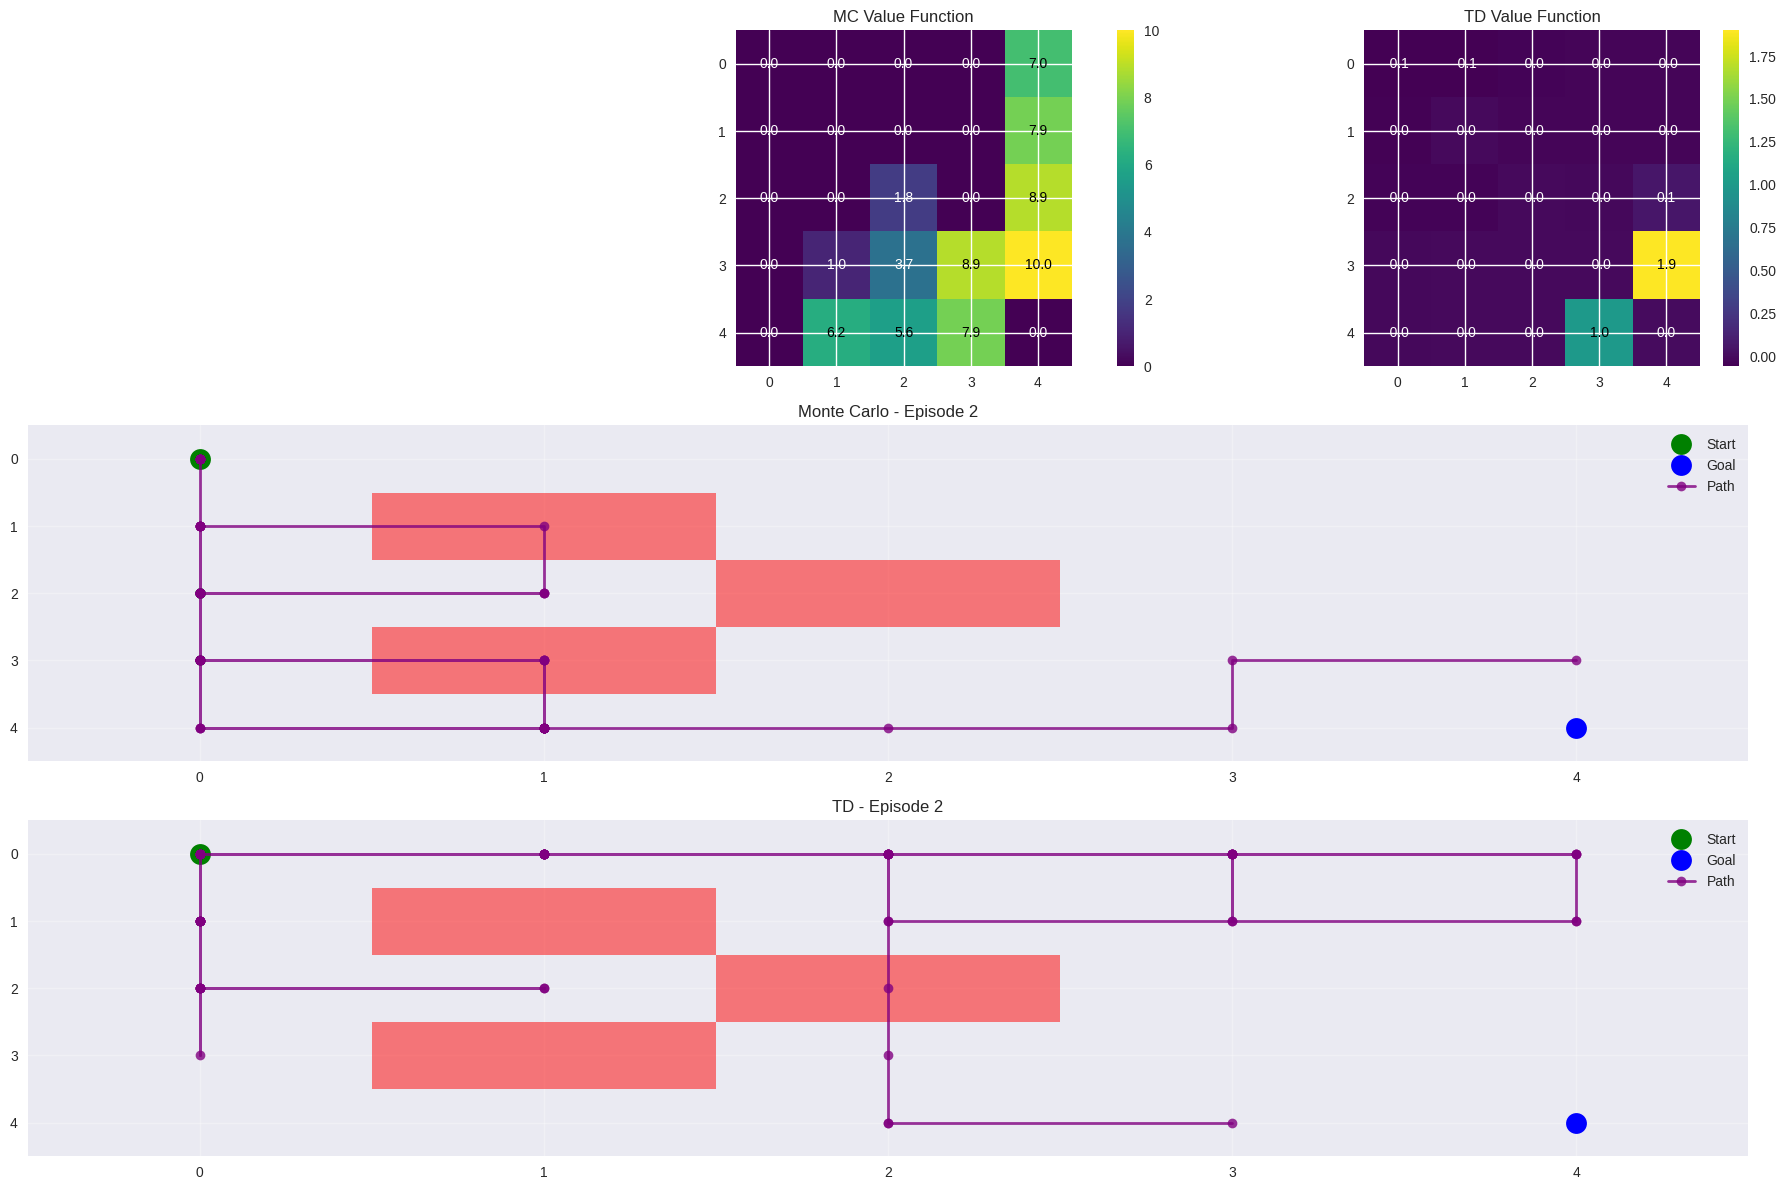

<Figure size 800x550 with 0 Axes>

Episode 2: MC Return = -21.5, TD Return = 1.1


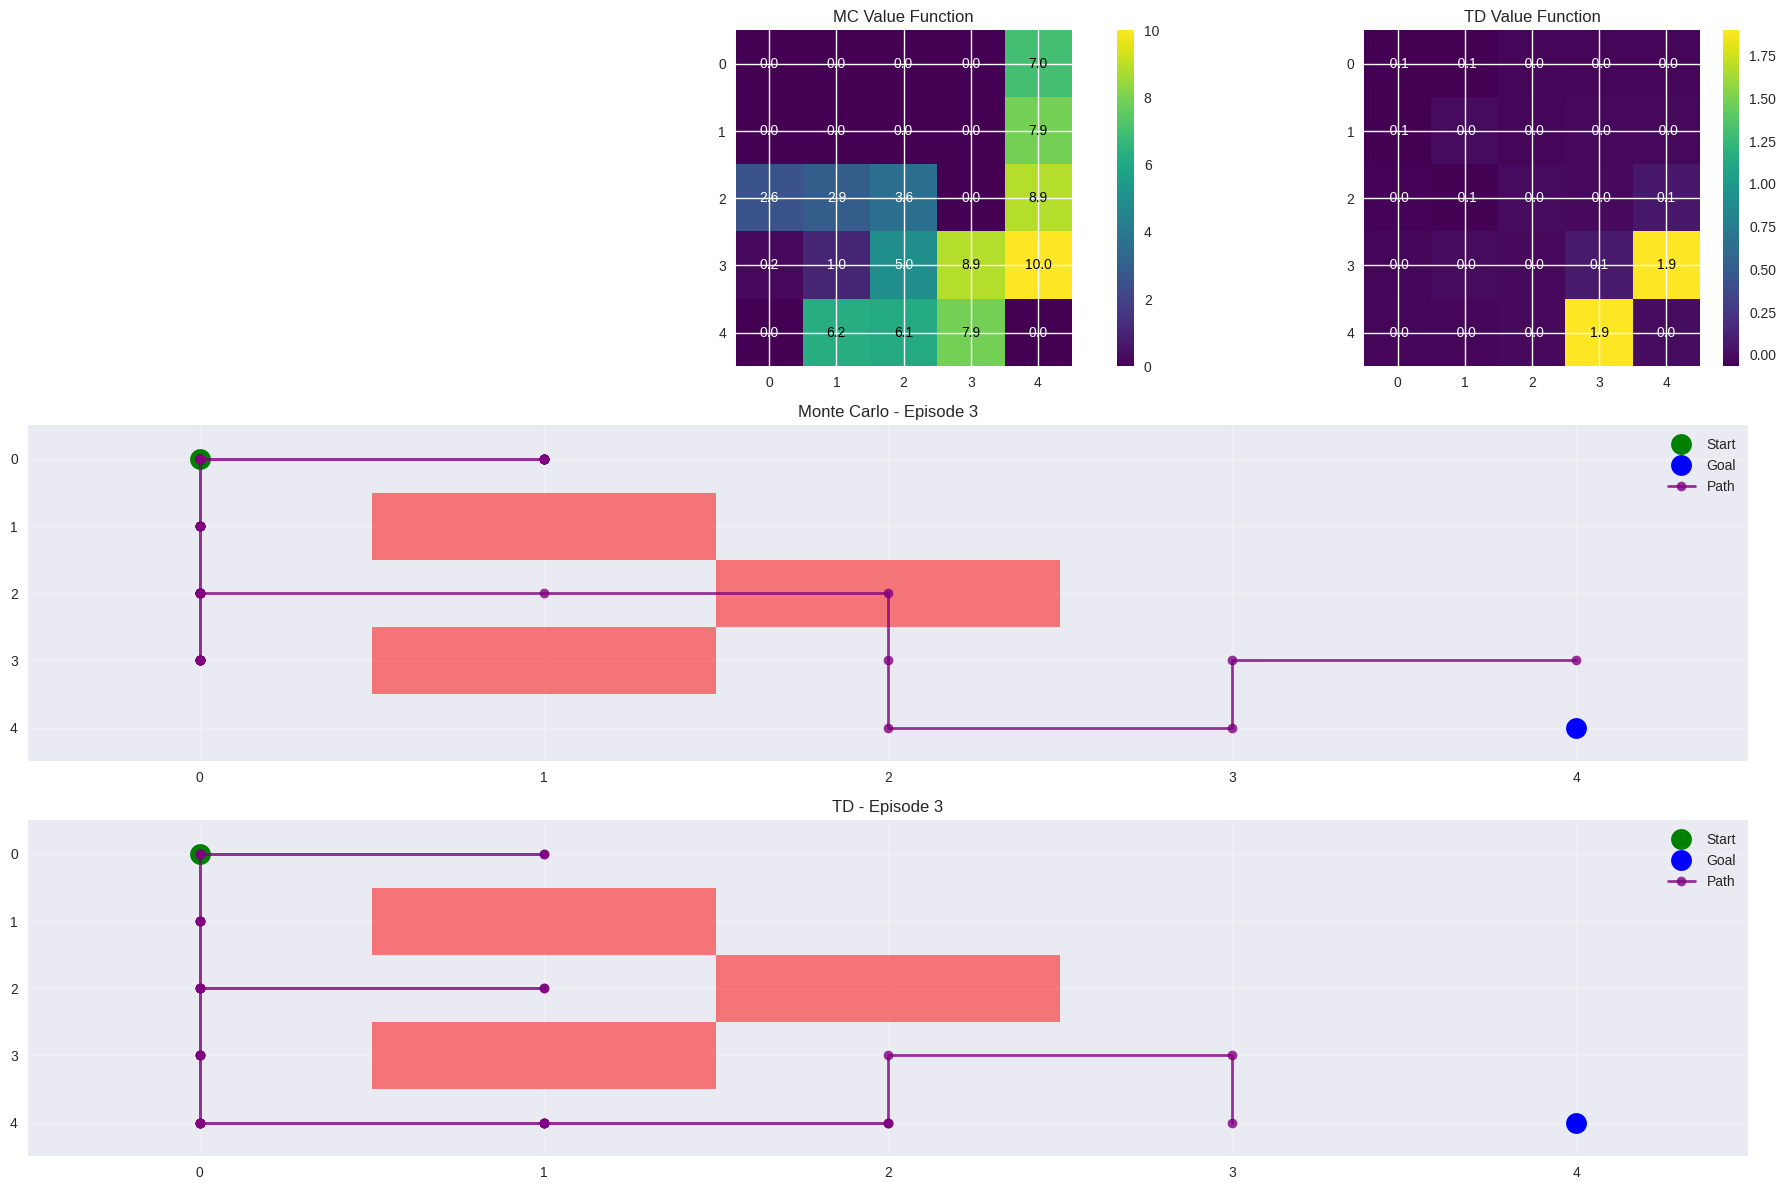

<Figure size 800x550 with 0 Axes>

Episode 3: MC Return = -6.5, TD Return = 5.5


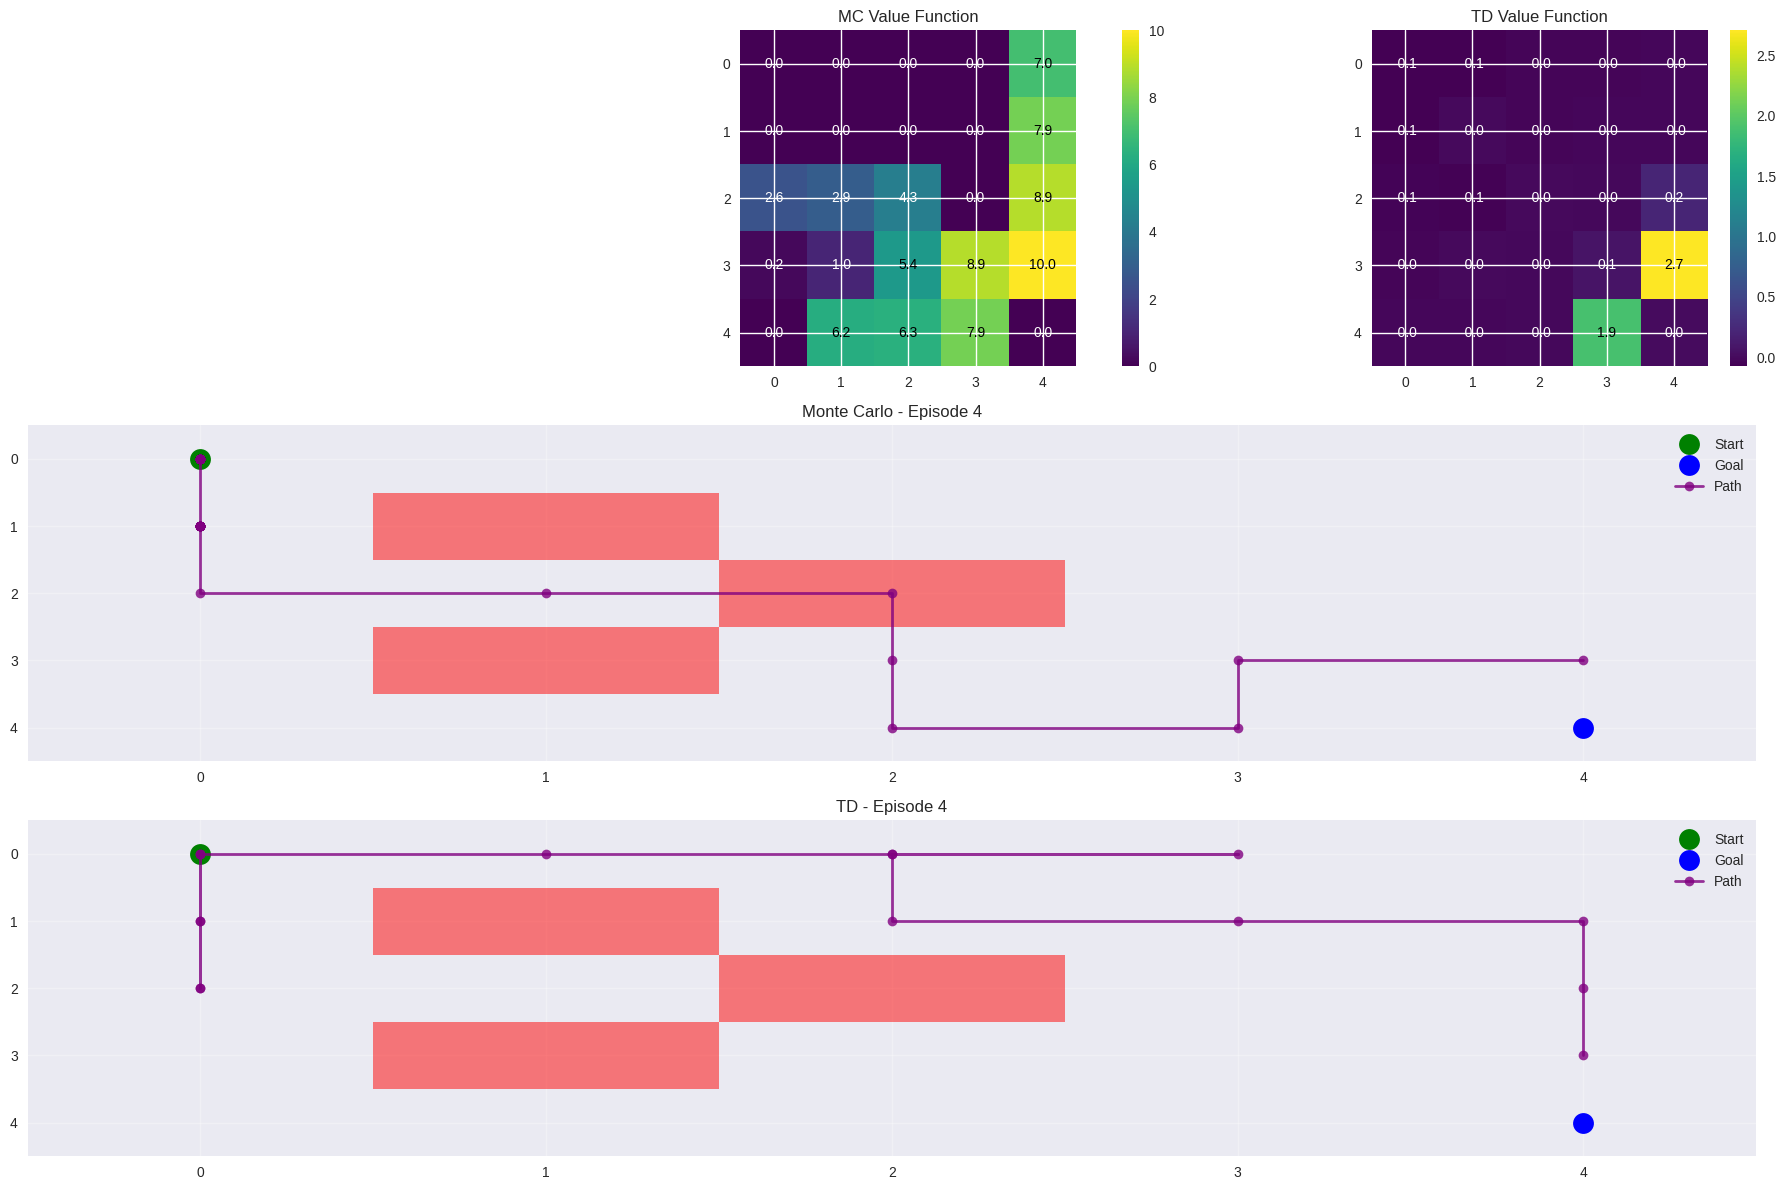

<Figure size 800x550 with 0 Axes>

Episode 4: MC Return = 3.1, TD Return = 8.5


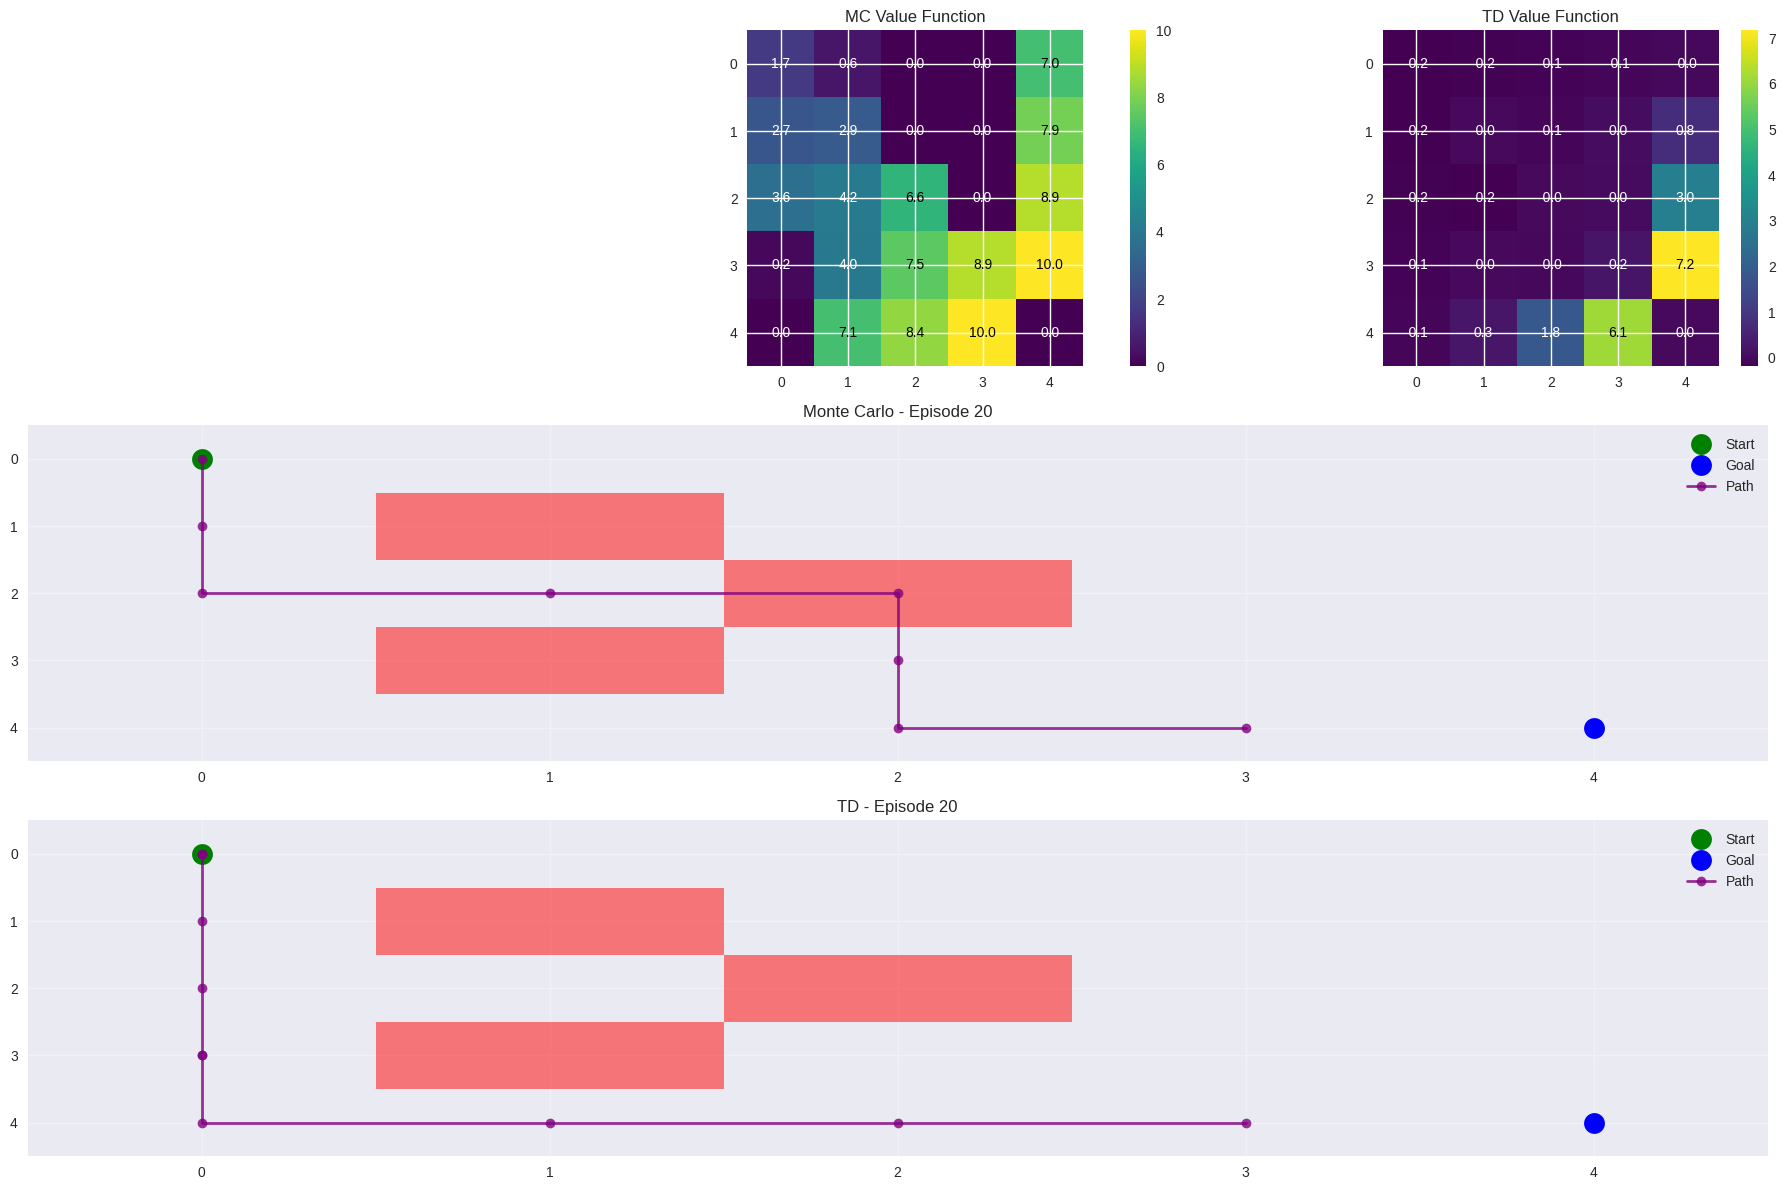

<Figure size 800x550 with 0 Axes>

Episode 20: MC Return = 7.4, TD Return = 9.1


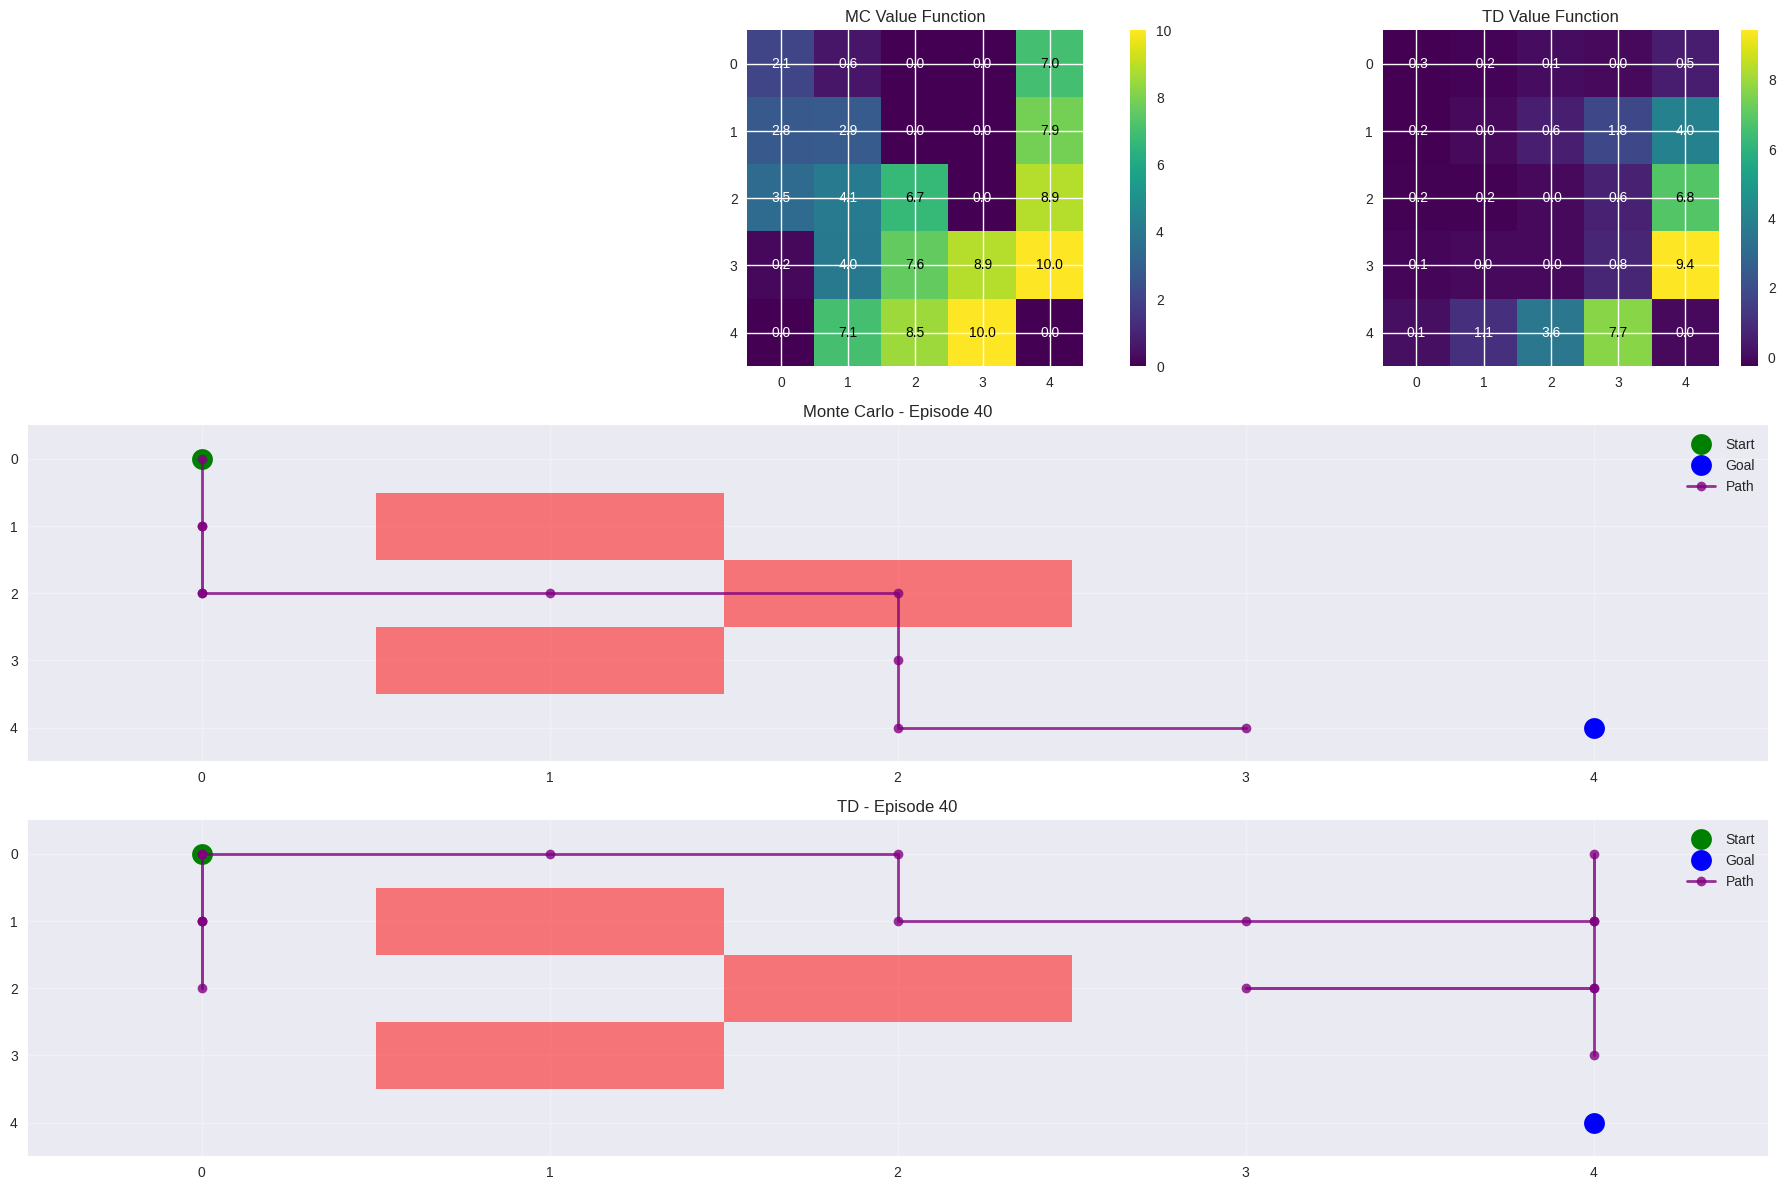

<Figure size 800x550 with 0 Axes>

Episode 40: MC Return = 7.2, TD Return = 8.4


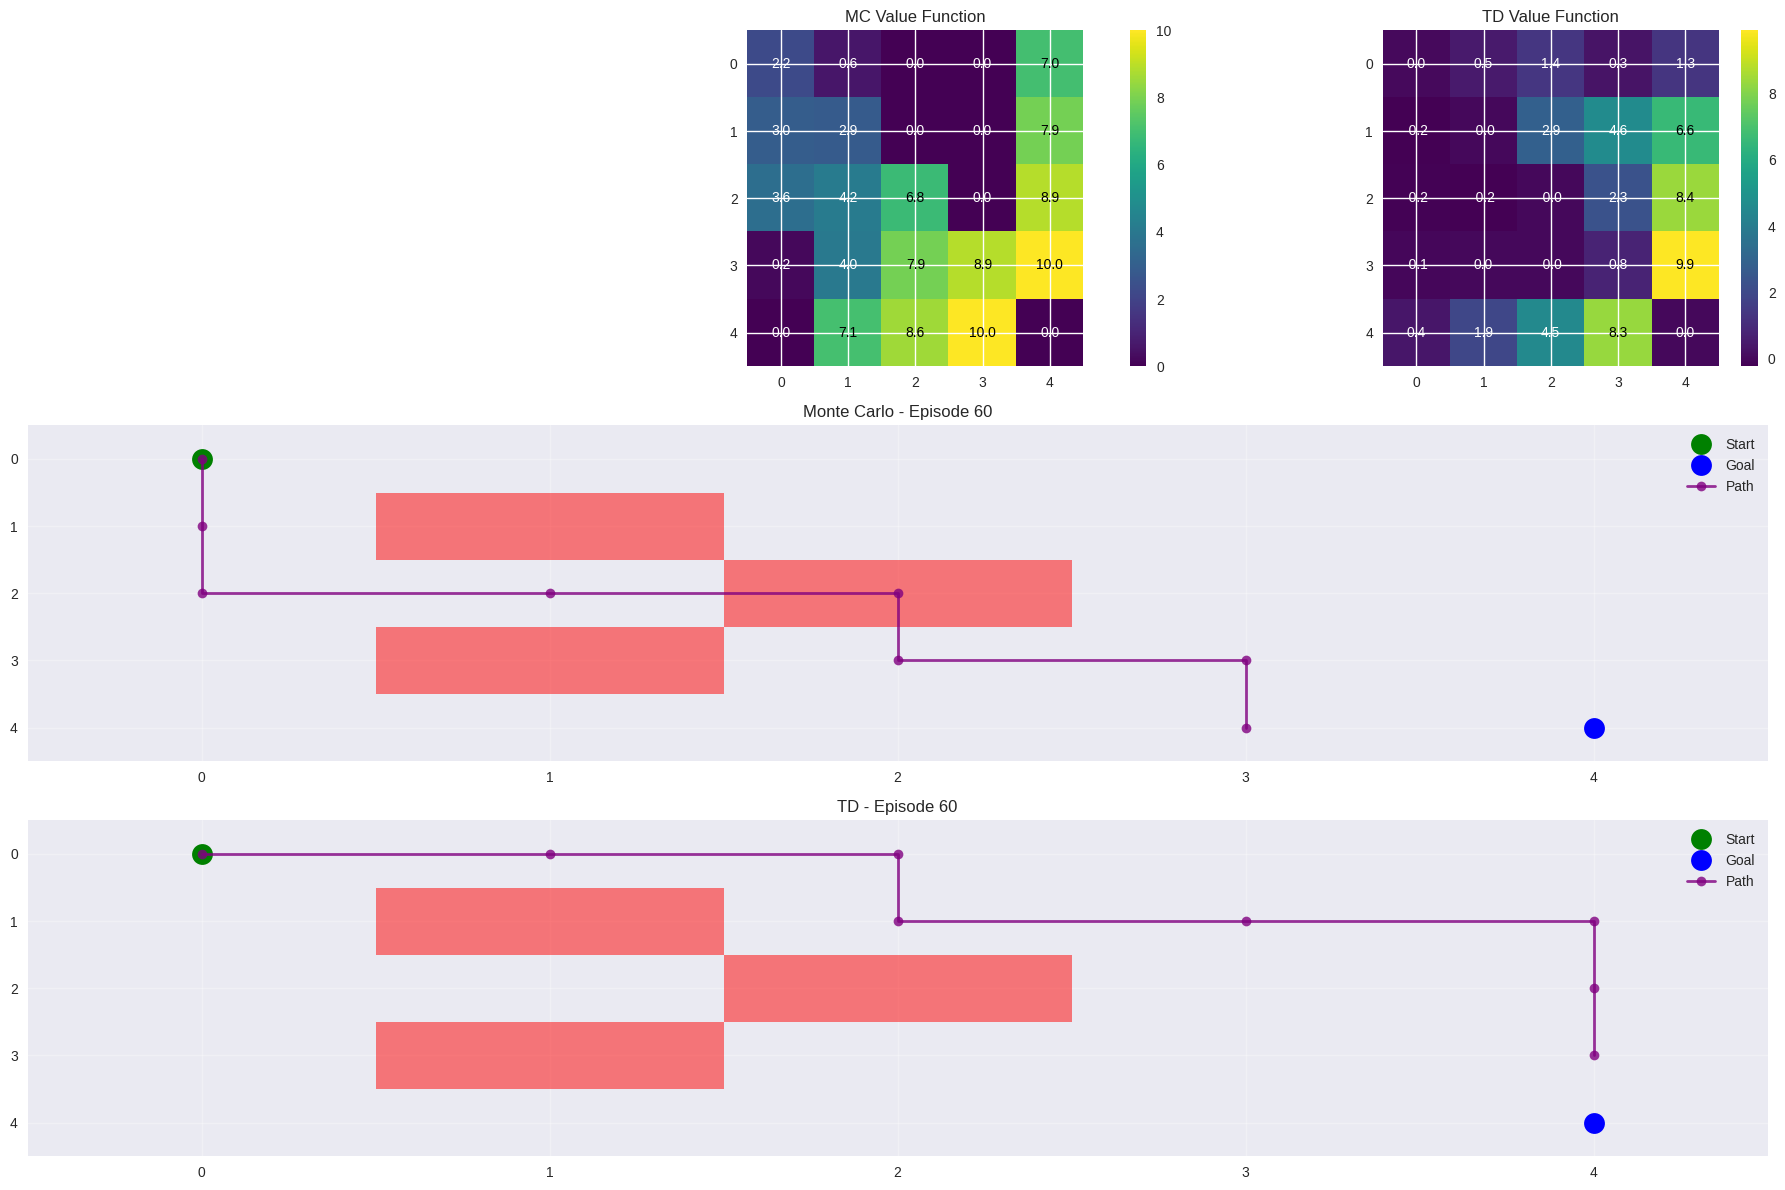

<Figure size 800x550 with 0 Axes>

Episode 60: MC Return = 7.4, TD Return = 9.3


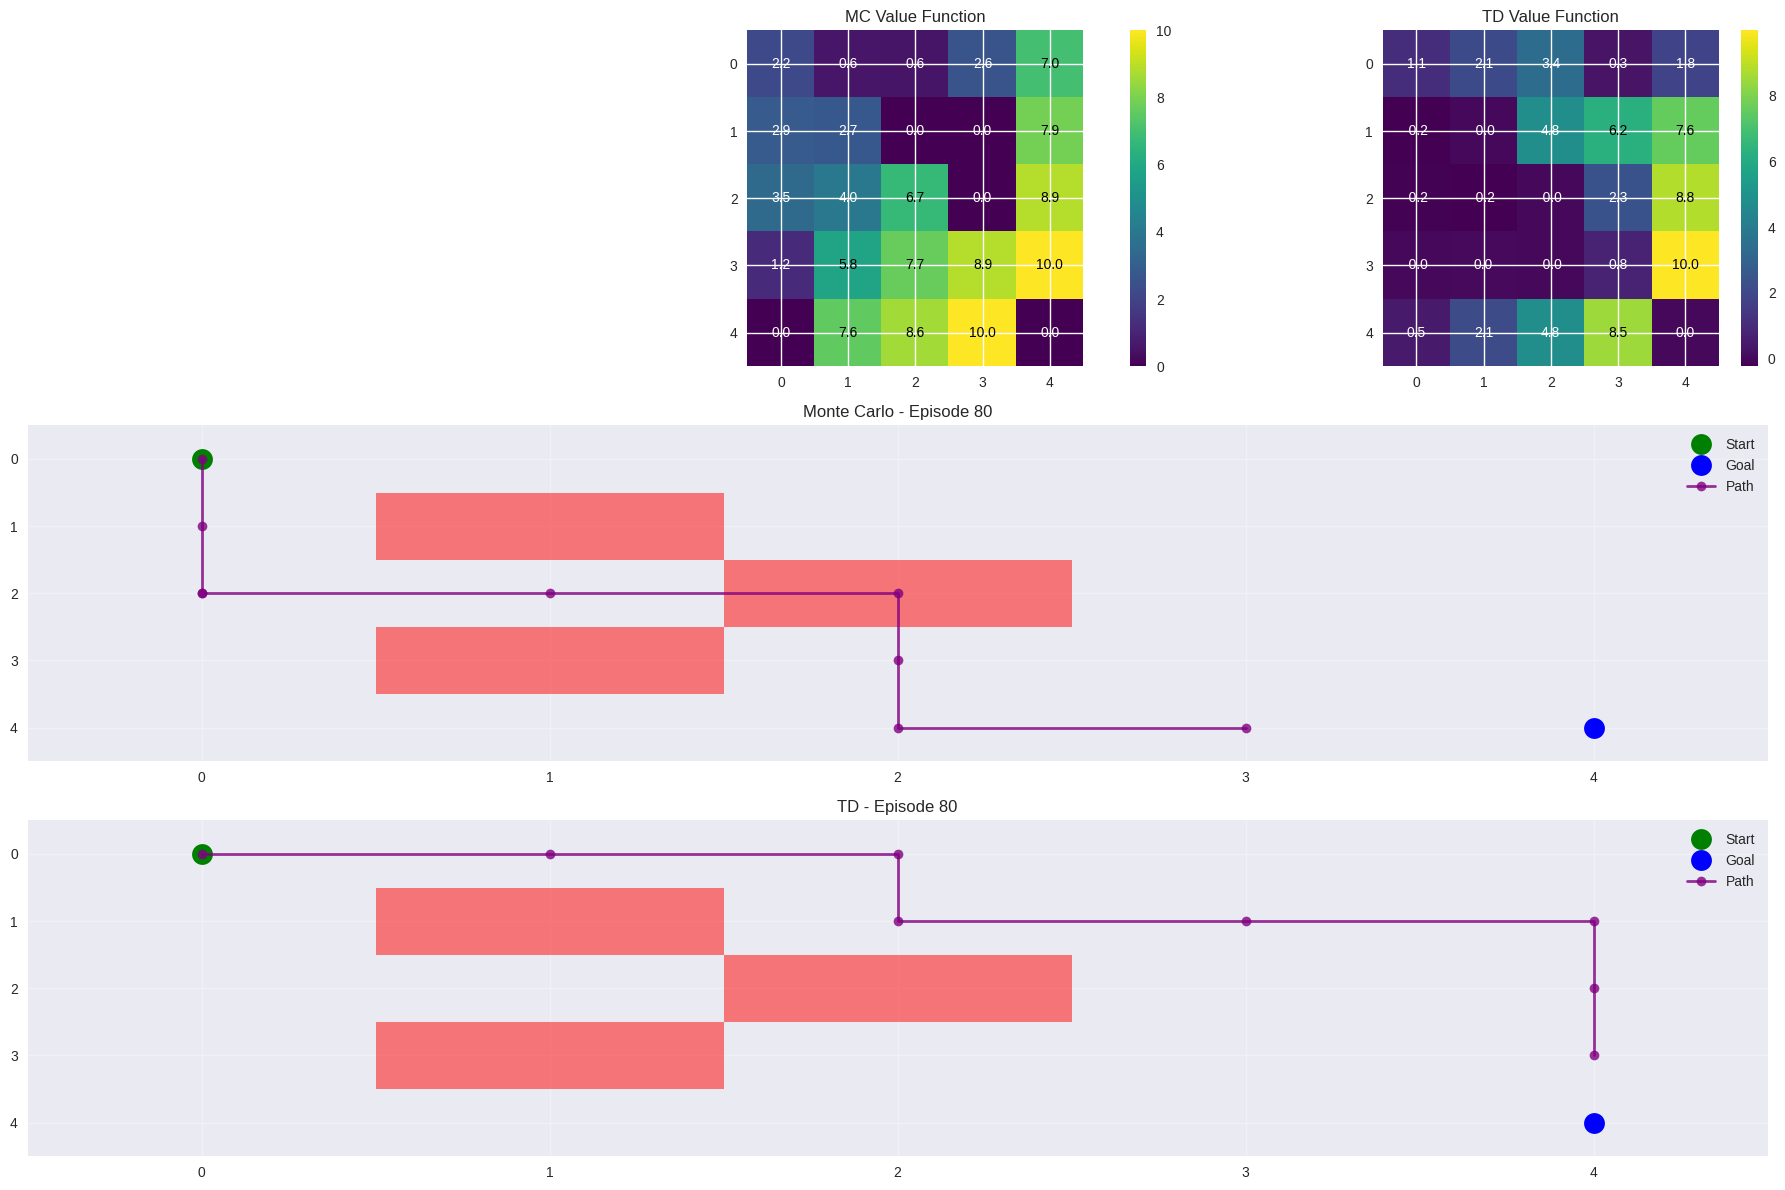

<Figure size 800x550 with 0 Axes>

Episode 80: MC Return = 7.3, TD Return = 9.3


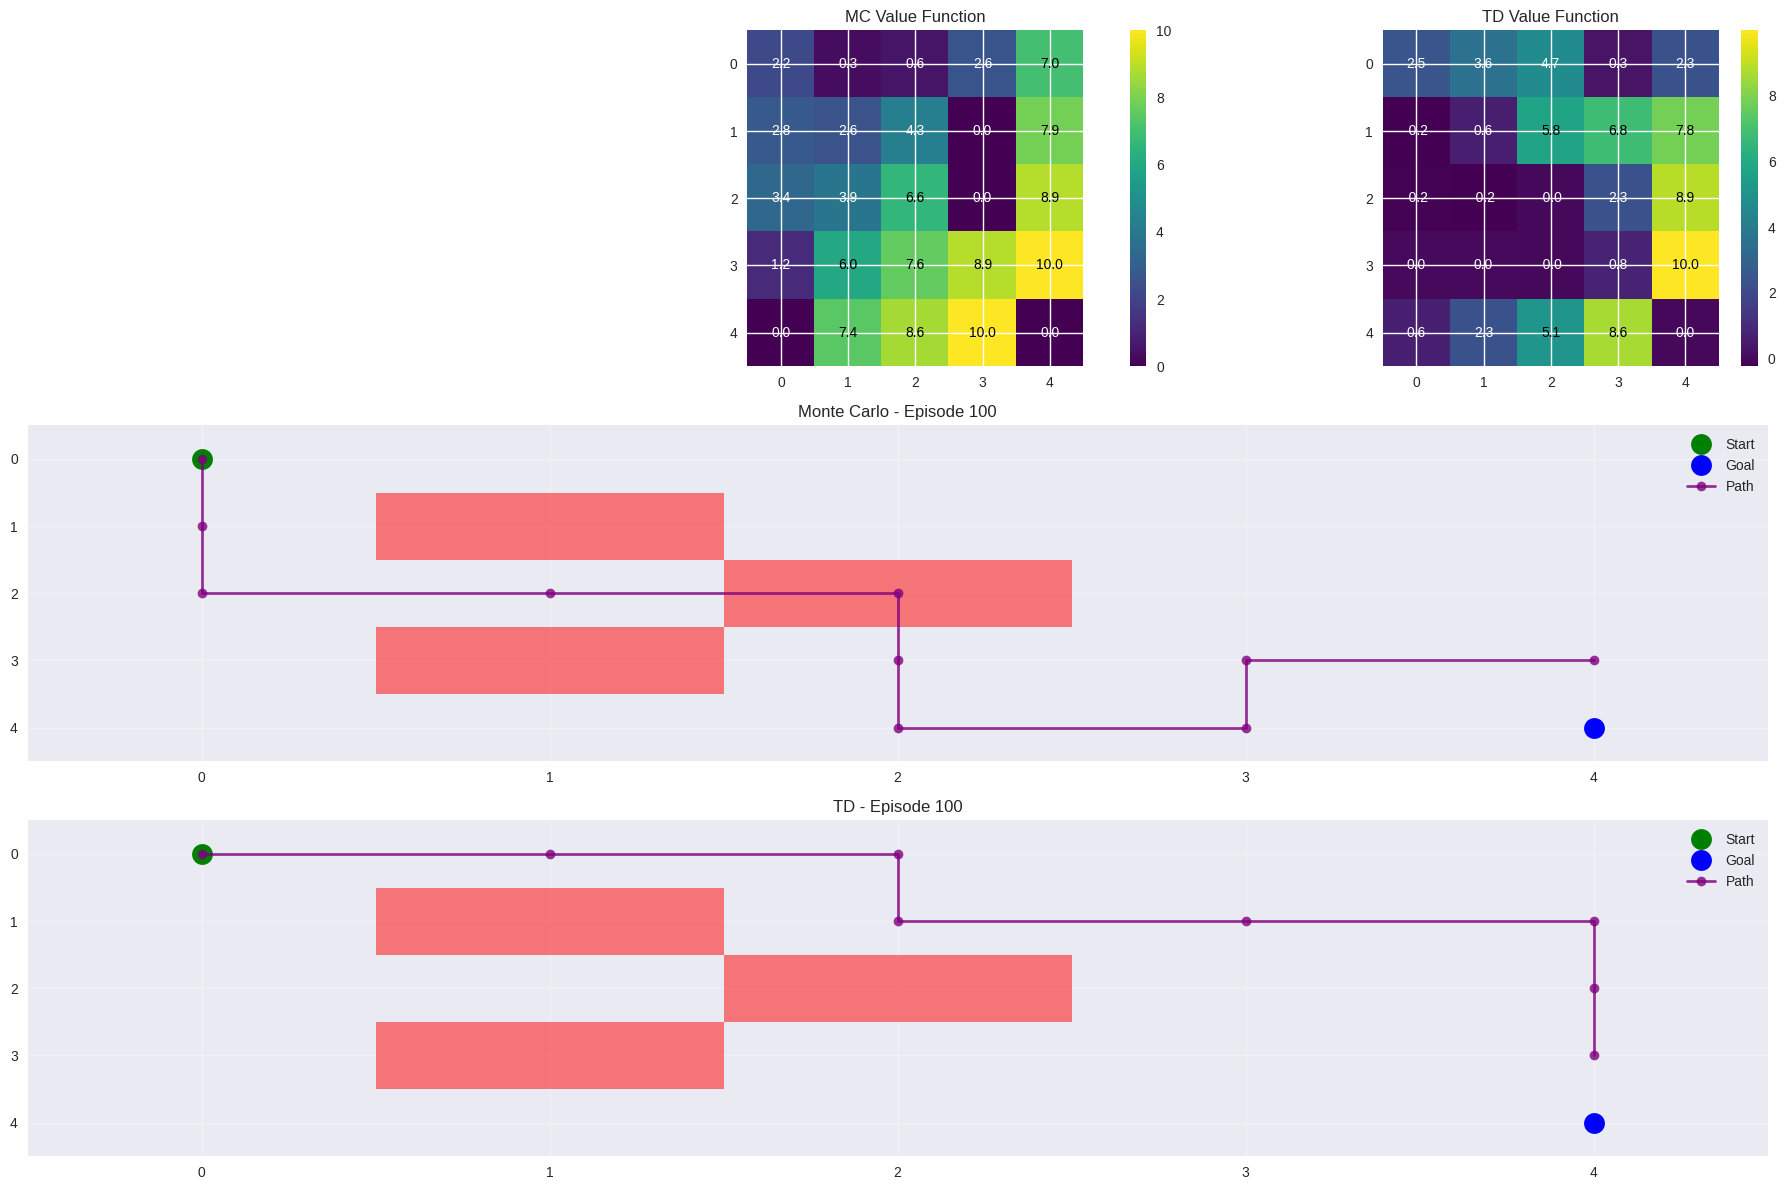

<Figure size 800x550 with 0 Axes>

Episode 100: MC Return = 7.2, TD Return = 9.3


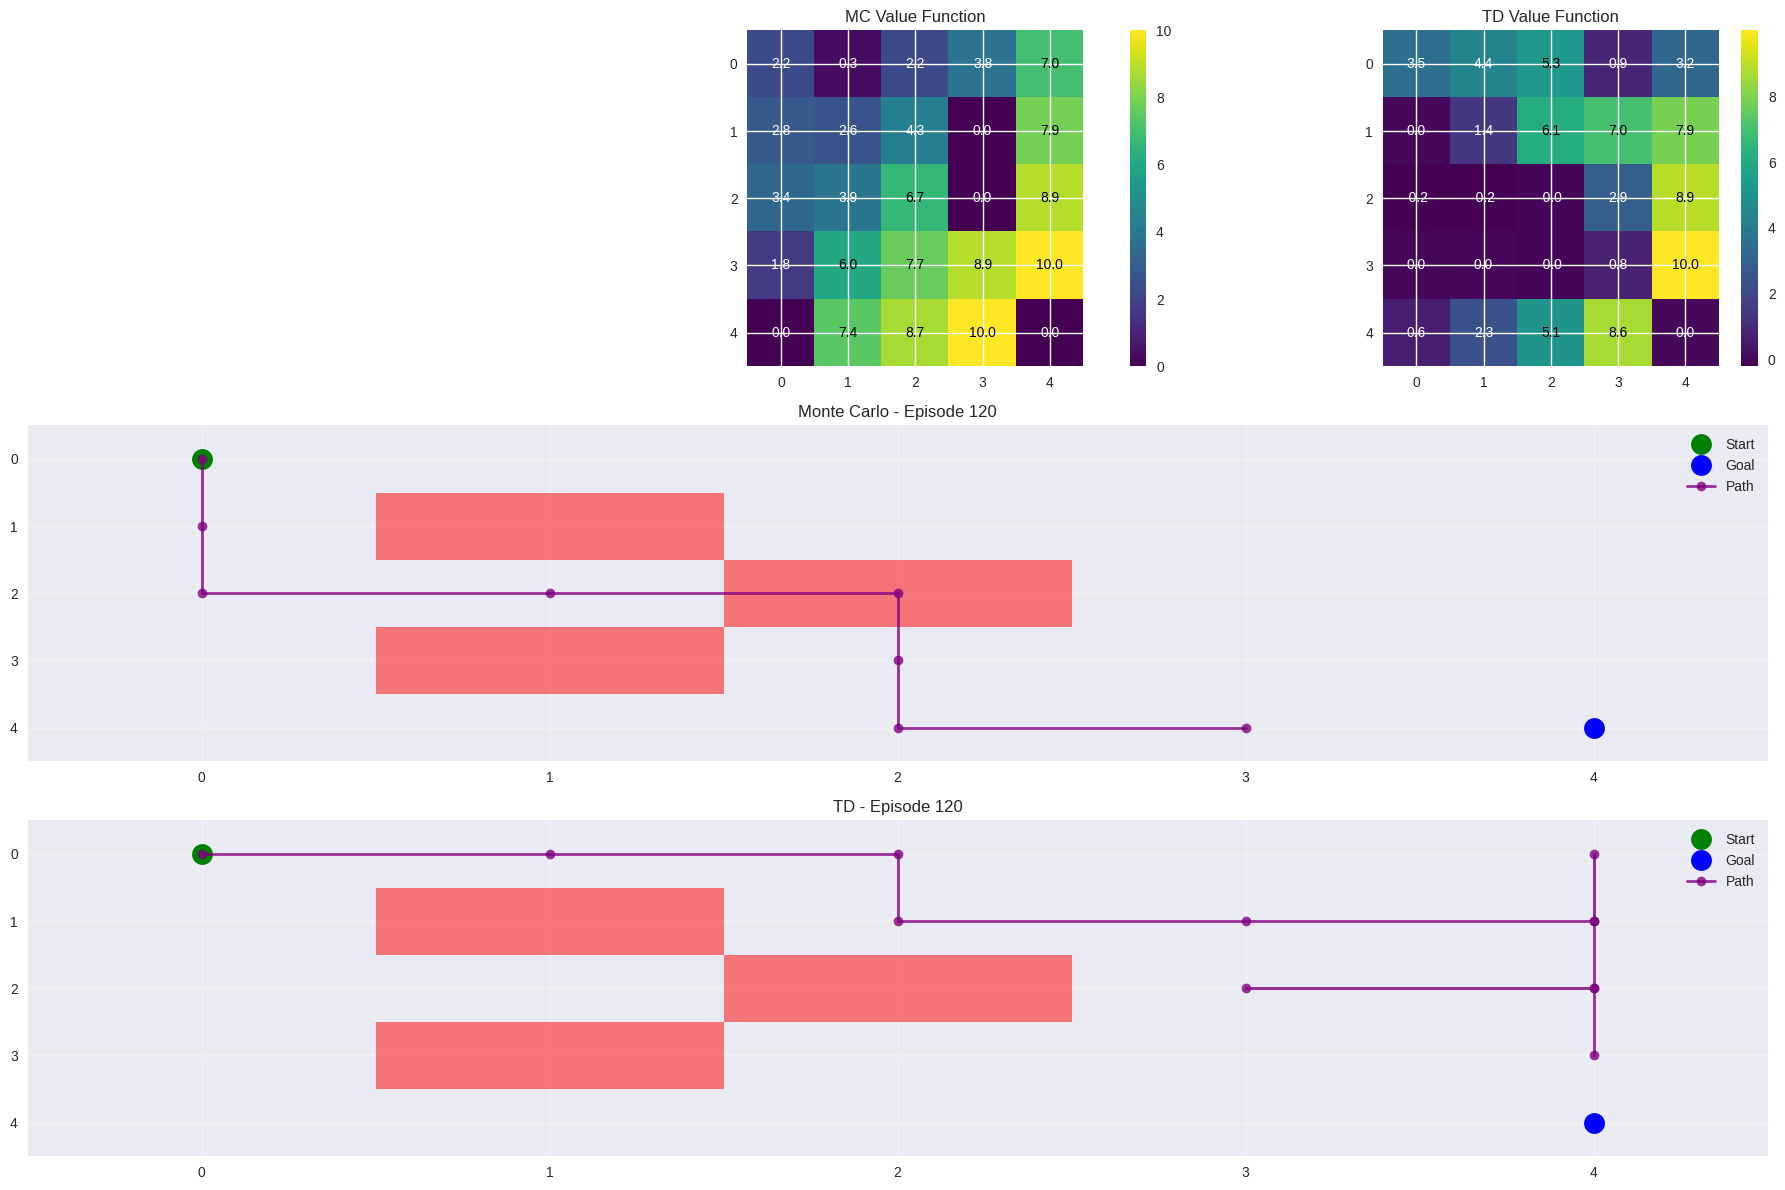

<Figure size 800x550 with 0 Axes>

Episode 120: MC Return = 7.4, TD Return = 8.9


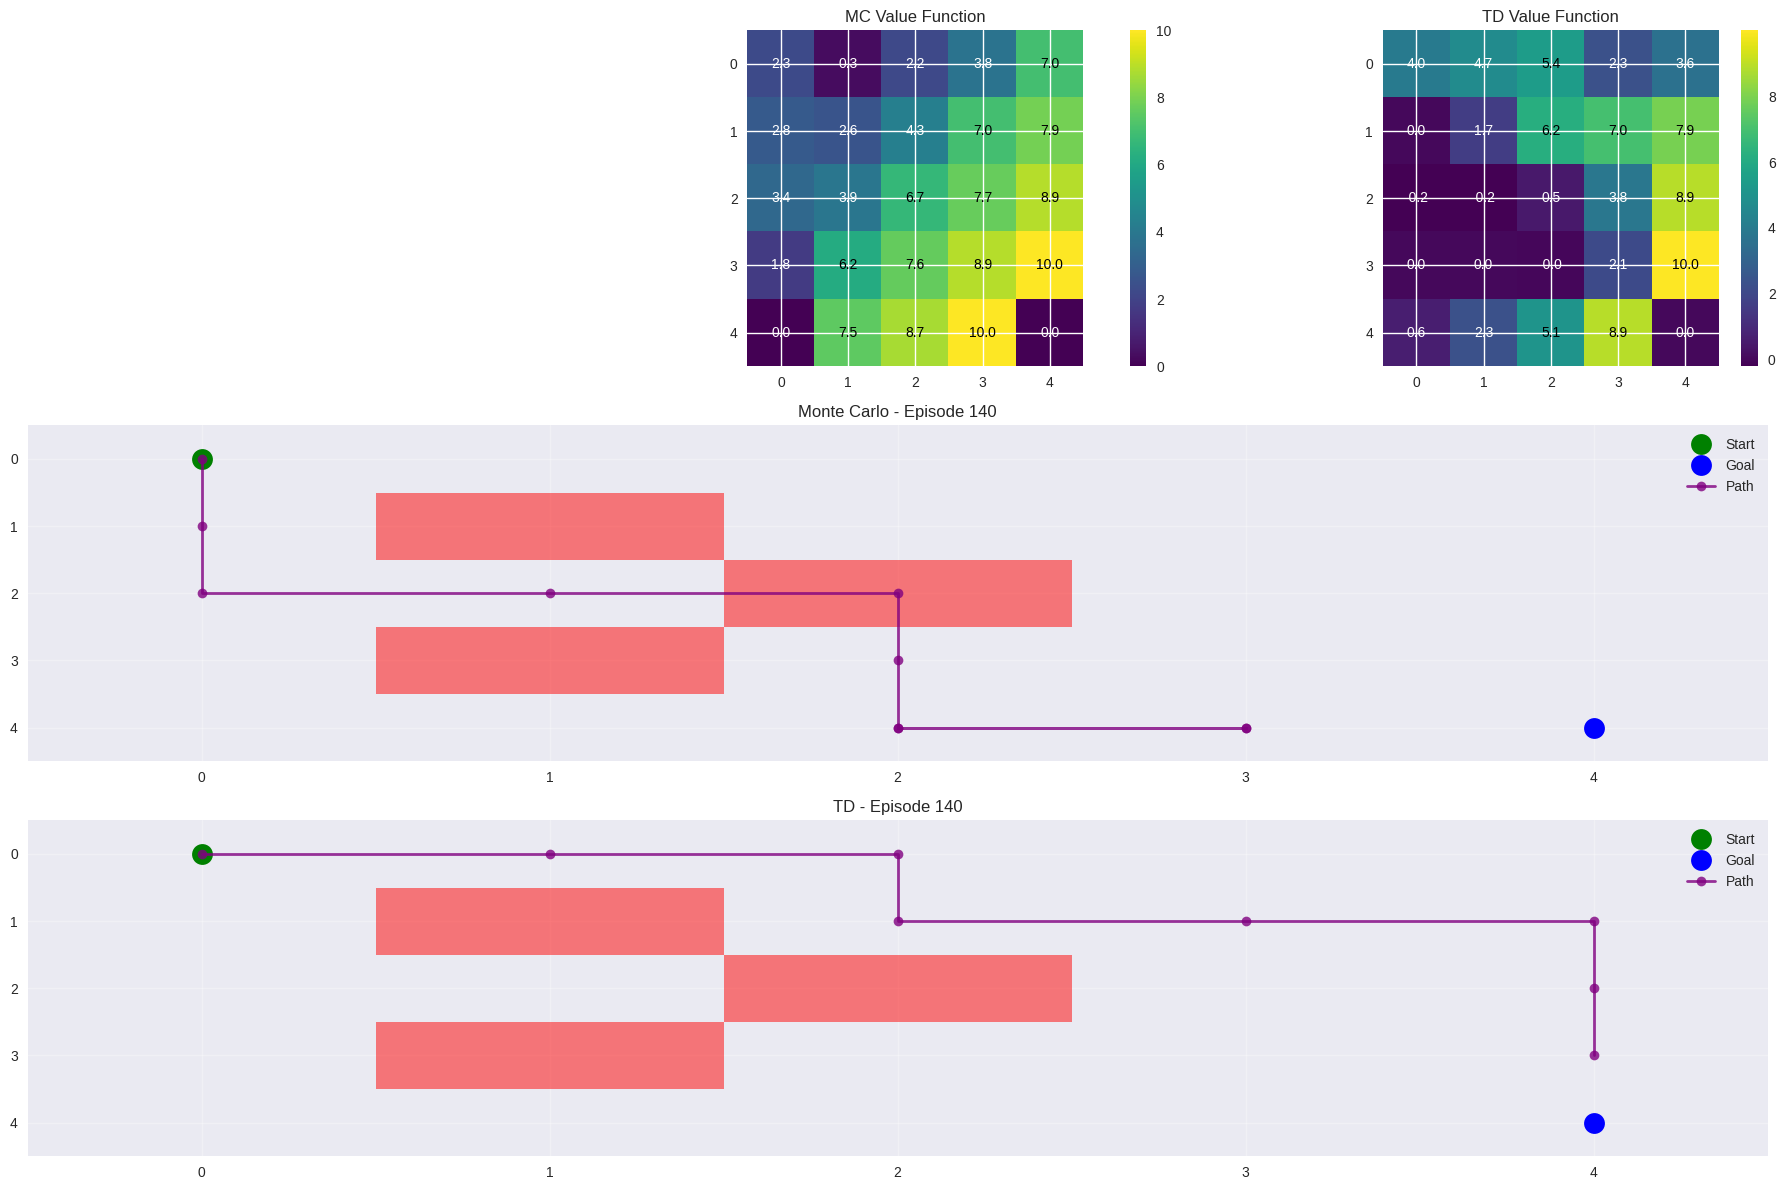

<Figure size 800x550 with 0 Axes>

Episode 140: MC Return = 7.2, TD Return = 9.3


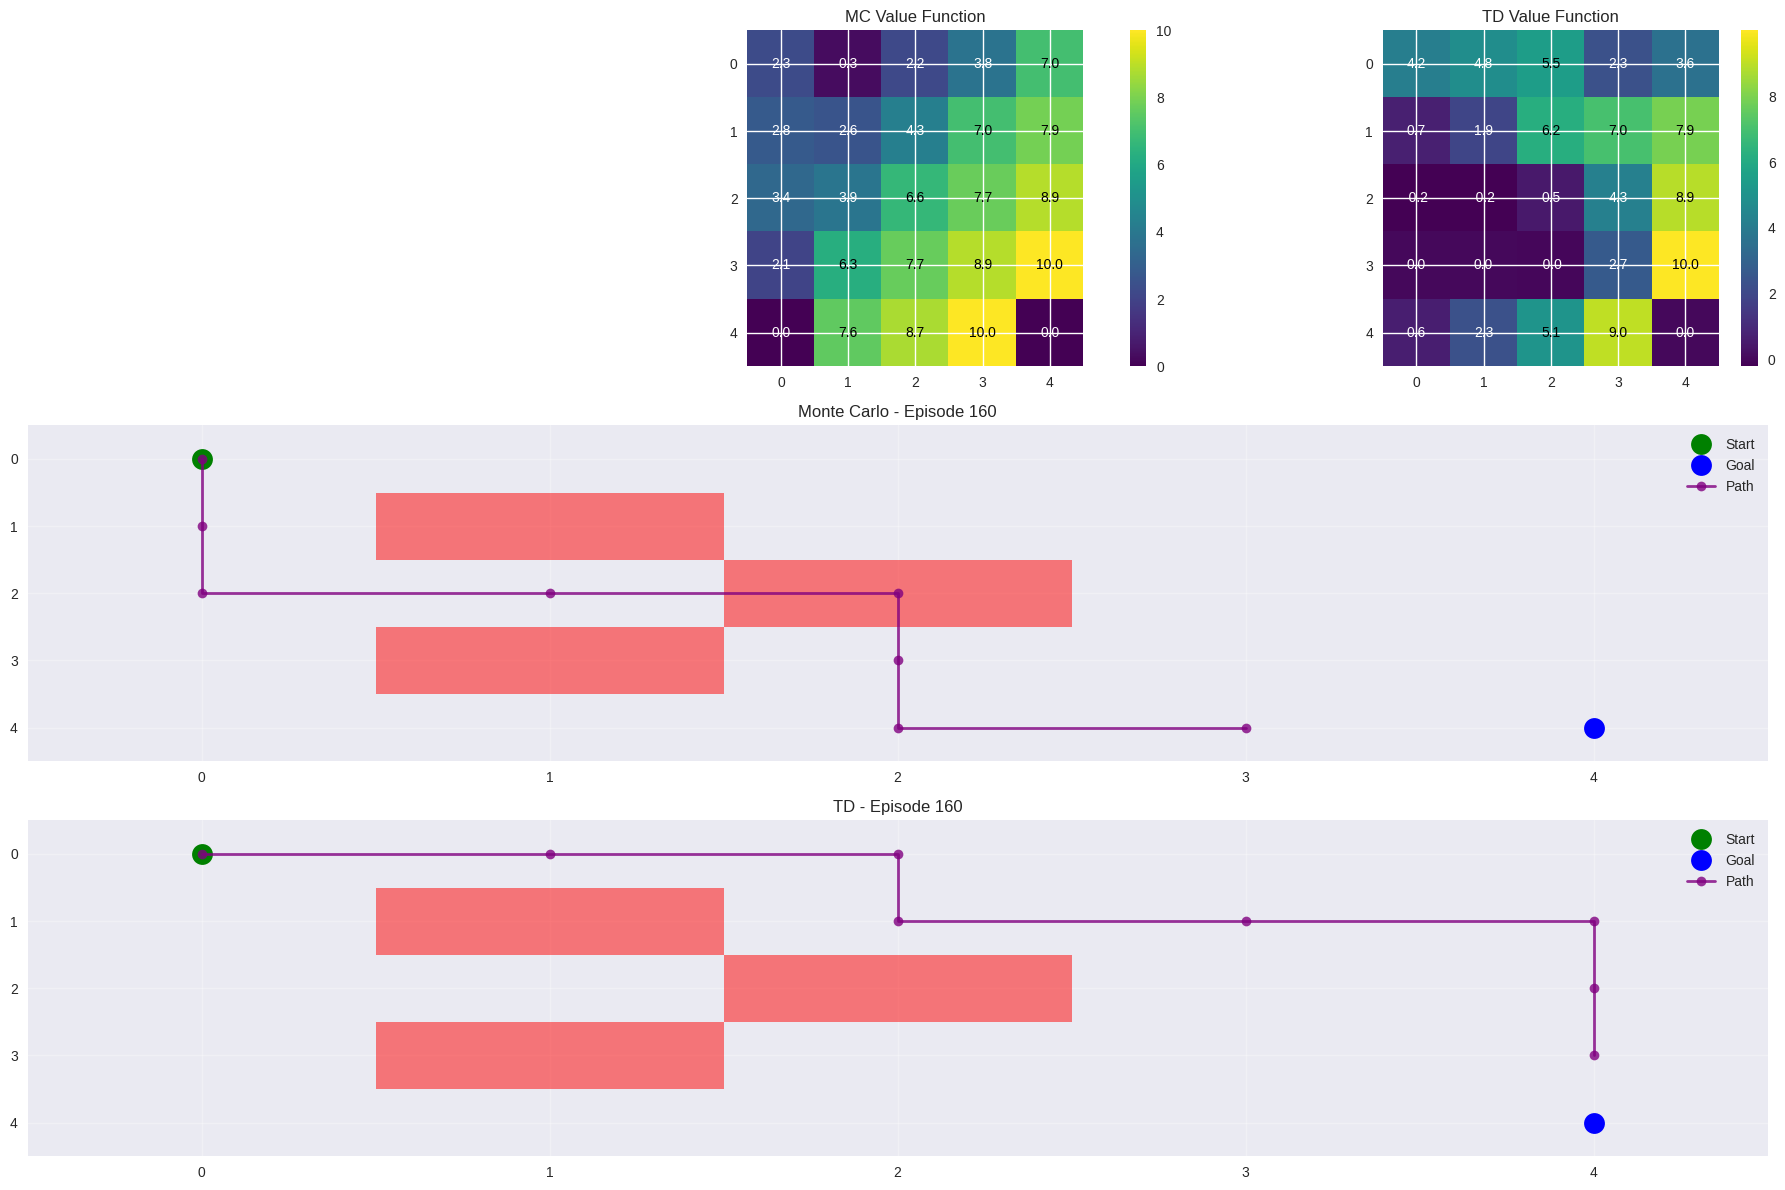

<Figure size 800x550 with 0 Axes>

Episode 160: MC Return = 7.4, TD Return = 9.3


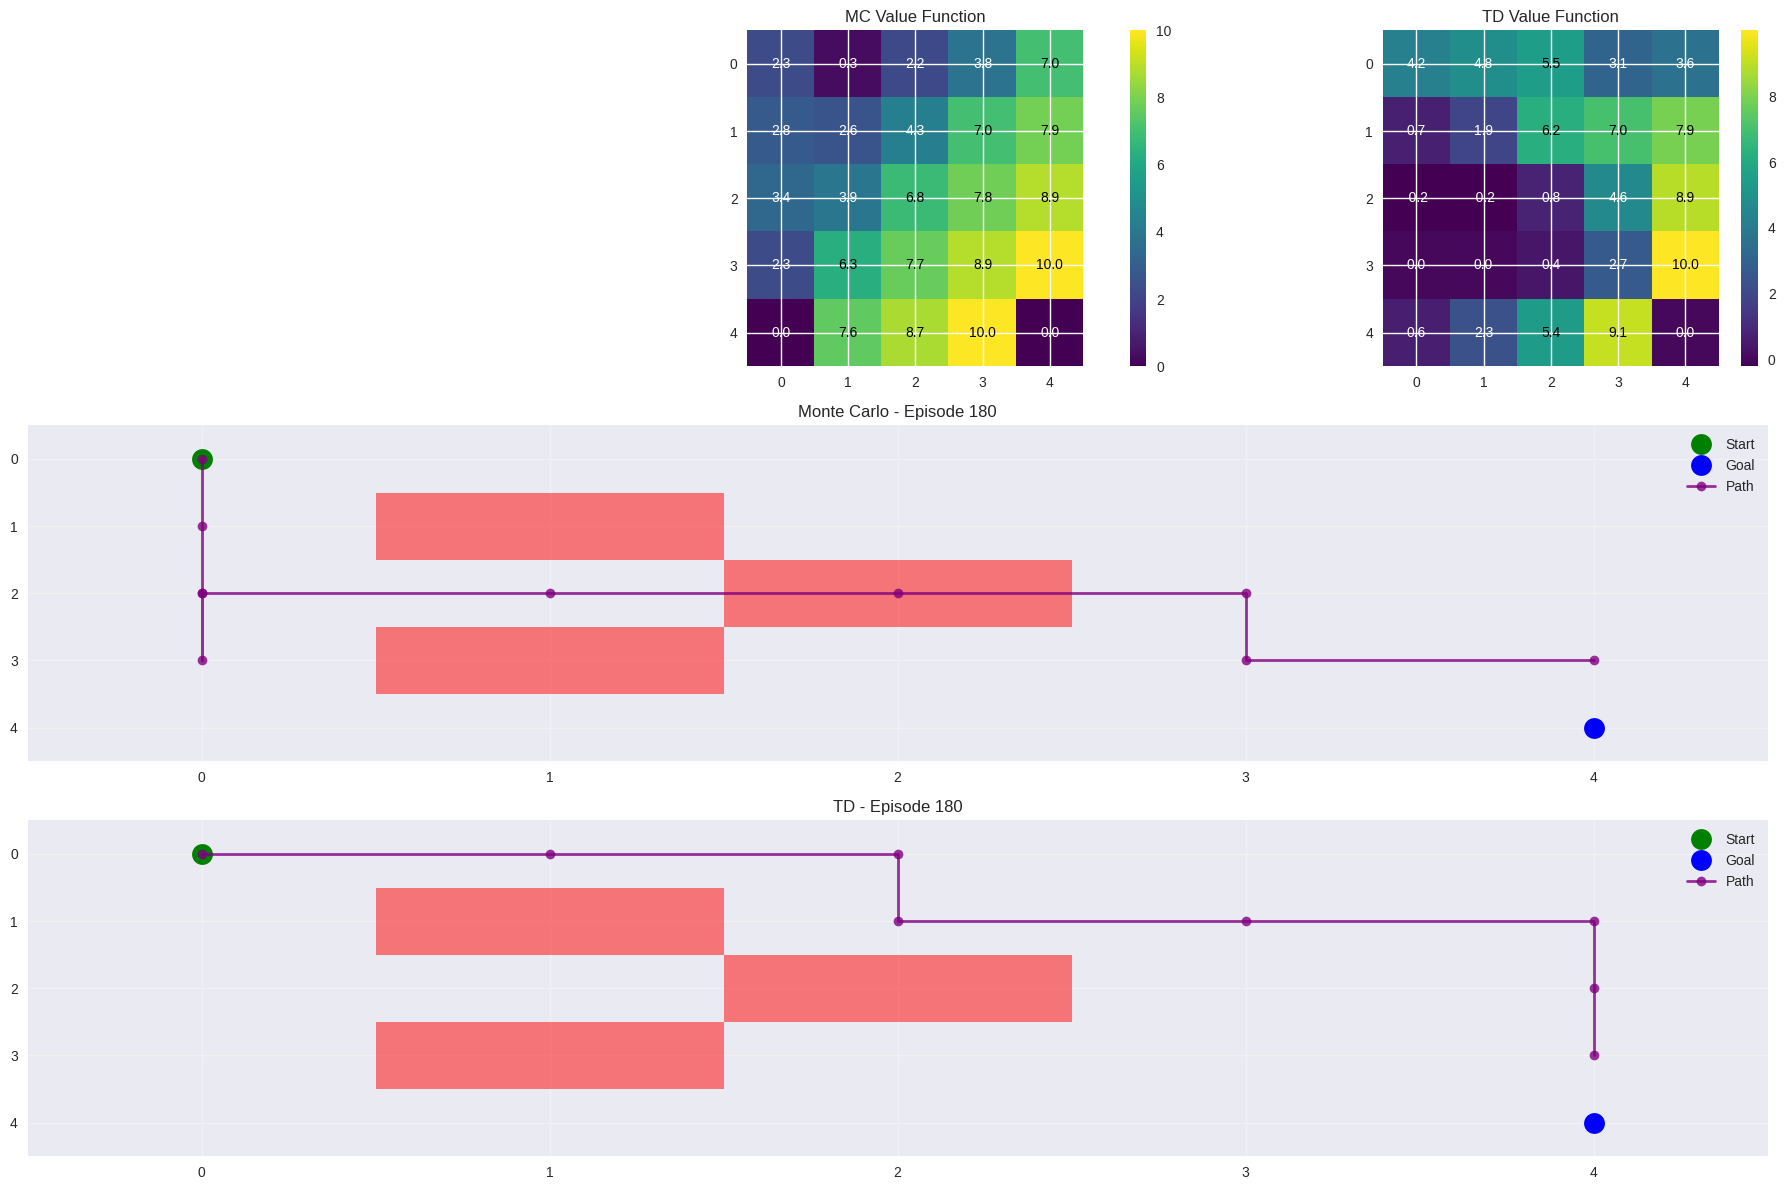

<Figure size 800x550 with 0 Axes>

Episode 180: MC Return = 7.2, TD Return = 9.3


In [22]:

env = GridWorld()
mc_agent = MonteCarlo(env)
td_agent = TemporalDifference(env)

num_episodes = 200

for episode in range(num_episodes):
    mc_episode = mc_agent.generate_episode(epsilon=0.1)
    td_episode = td_agent.generate_episode(epsilon=0.1)

    mc_agent.update_value_function(mc_episode)

    # Visualize every 20 episodes
    if episode % 20 == 0 or episode < 5:
        fig = create_visualization(env, mc_agent, td_agent, episode)
        plt.suptitle(f'Episode {episode}', fontsize=16)
        plt.show()

        mc_return = sum([step[2] for step in mc_episode])
        td_return = sum([step[2] for step in td_episode])
        print(f"Episode {episode}: MC Return = {mc_return:.1f}, TD Return = {td_return:.1f}")


